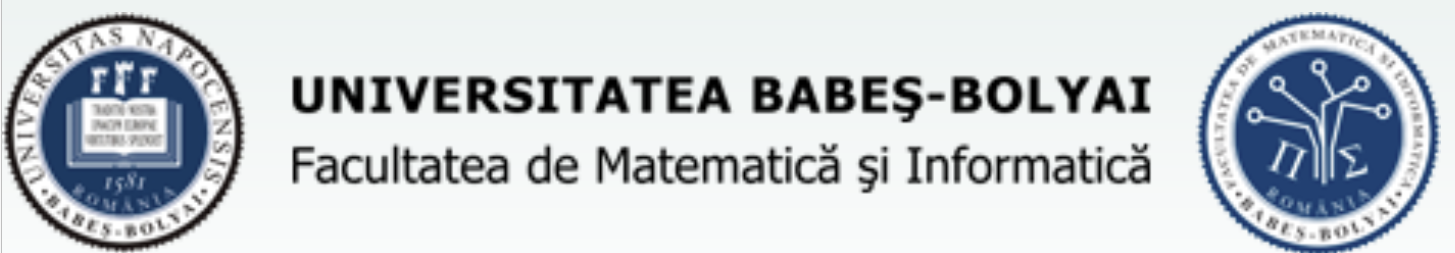

# Julia starter notebook to solve the <br/> Blood spectroscopy classification project

This is a "starter notebook" that
1. loads the data;
1. displays the basic statistics;
1. performs the transformations to make the data-set amenable for _training_


In [127]:
# reading in the data
import CSV, DataFrames
using DecisionTree
using MLBase
using Random
using DataFrames

train_data = CSV.read("Train.csv", DataFrames.DataFrame, header=true)
@info "size of the training data-set: ", size(train_data);

┌ Info: ("size of the training data-set: ", (13140, 176))
└ @ Main In[127]:9


In [128]:
tr(s::String) = (s=="ok") ? 1 : ((s=="low") ? 0 : 2)
# map(tr, String.(train_data[!,:hemoglobin_human]))
# equivalent format
ch_ldl = map(tr, String.(train_data.cholesterol_ldl_human)) # observe the different syntax of the 
ch_hdl = map(tr, String.(train_data.hdl_cholesterol_human)) # observe the different syntax of the 
ch_hgb = map(tr, String.(train_data.hemoglobin_human)) # observe the different syntax of the 
;

In [129]:
# transforming the DATAFRAME into a matrix
ids = setdiff(2:172,[171, 172]);
x = Matrix( train_data[!,2:173] );

In [130]:
typeof(x)

Matrix{Float64} (alias for Array{Float64, 2})

In [131]:
size(x)

(13140, 172)

In [132]:
# We will train 3 different models, one for hdl cholesterol, ldl cholesterol and hemoglobin
y_hgb = ch_hgb; 
y_hdl = ch_hdl;
y_ldl = ch_ldl;

In [133]:
# This function splits the data into training and testing, while making sure data from each class will be added in both sets
function perclass_splits(y,at, at2)
    uids = unique(y)
    keepids = []
    for ui in uids
        if ui == 1
            at = at2
        end    
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end

perclass_splits (generic function with 2 methods)

In [145]:
trainids_hgb = perclass_splits(y_hgb,0.7, 0.2);
testids_hgb = setdiff(1:length(y_hgb),trainids_hgb);

trainids_hdl = perclass_splits(y_hdl,0.7, 0.4);
testids_hdl = setdiff(1:length(y_hdl),trainids_hdl);

trainids_ldl = perclass_splits(y_ldl,0.7, 0.6);
testids_ldl = setdiff(1:length(y_ldl),trainids_ldl);

In [146]:
# Training the models

model_hgb = RandomForestClassifier(n_trees=50)
DecisionTree.fit!(model_hgb, x[trainids_hgb,:], y_hgb[trainids_hgb])

RandomForestClassifier
n_trees:             50
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [0, 1, 2]
ensemble:            Ensemble of Decision Trees
Trees:      50
Avg Leaves: 61.12
Avg Depth:  13.62

In [147]:
model_hdl = RandomForestClassifier(n_trees=50)
DecisionTree.fit!(model_hdl, x[trainids_hdl,:], y_hdl[trainids_hdl])

RandomForestClassifier
n_trees:             50
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [0, 1, 2]
ensemble:            Ensemble of Decision Trees
Trees:      50
Avg Leaves: 214.0
Avg Depth:  21.44

In [148]:
model_ldl = RandomForestClassifier(n_trees=50)
DecisionTree.fit!(model_ldl, x[trainids_ldl,:], y_ldl[trainids_ldl])

RandomForestClassifier
n_trees:             50
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [0, 1, 2]
ensemble:            Ensemble of Decision Trees
Trees:      50
Avg Leaves: 247.14
Avg Depth:  20.46

In [149]:
# Method for computing the accuracy of a model

findaccuracy(predictedvals,groundtruthvals) = sum(predictedvals.==groundtruthvals)/length(groundtruthvals)

findaccuracy (generic function with 1 method)

In [150]:
# Accuracy for HGB

q = x[testids_hgb,:];
predictions_RF = DecisionTree.predict(model_hgb, q)
findaccuracy(predictions_RF,y_hgb[testids_hgb])

0.9782793464916423

In [151]:
# Accuracy for HDL

q = x[testids_hdl,:];
predictions_RF = DecisionTree.predict(model_hdl, q)
findaccuracy(predictions_RF,y_hdl[testids_hdl])

0.9889516957862282

In [152]:
# Accuracy for LDL

q = x[testids_ldl,:];
predictions_RF = DecisionTree.predict(model_ldl, q)
findaccuracy(predictions_RF,y_ldl[testids_ldl])

0.9951811873554356

In [142]:
test_data = CSV.read("Updated_Test.csv", DataFrames.DataFrame, header=true);
@info "size of the testing data-set: ", size(test_data);

ids = setdiff(3:176,[173, 174]);
x_test = Matrix( test_data[!,ids] );

┌ Info: ("size of the testing data-set: ", (3660, 176))
└ @ Main In[142]:2


In [143]:
# Aggregating the predictions

function filter(x)
    c1 = 0;
    c2 = 0;
    c0 = 0;
    for element in x
        if element == 1
            c1 += 1
        elseif element == 2
            c2 += 1
        else
            c0 += 1
        end
    end    
    
    maximum = max(c1,c2,c0)
    if c1 == maximum
        return 1;
    elseif c2 == maximum
        return 2;
    end
    return 0;
end

function result(x)
    if x == 0
        return "low"
    elseif x == 2
        return "high"
    end
    return "ok";
end

df = DataFrame(Reading_ID = [], target = [])
for id in unique(test_data[:,2])
    donation_data = test_data[test_data.donation_id .== id, :]
    x_test = Matrix( donation_data[!,ids] )
    ldl_test = DecisionTree.predict(model_ldl, x_test);
    hdl_test = DecisionTree.predict(model_hdl, x_test);
    hgb_test = DecisionTree.predict(model_hgb, x_test);
    count_ldl = filter(ldl_test)
    count_hdl = filter(hdl_test)
    count_hgb = filter(hgb_test)
    
    #print(result(count_ldl))
    print(count_ldl)
    push!(df, [id * "_cholesterol_ldl_human", result(count_ldl)])
    print(" ")
    #print(result(count_hdl))
    print(count_hdl)
    push!(df, [id * "_hdl_cholesterol_human", result(count_hdl)])
    print(" ")
    #print(result(count_hgb))
    print(count_hgb)
    push!(df, [id * "_hemoglobin(hgb)_human", result(count_hgb)])
    println(" ")
end
df

1 1 1 
2 1 1 
2 1 1 
1 1 1 
2 1 1 
2 1 1 
1 1 1 
1 0 1 
2 2 1 
1 1 1 
2 1 1 
2 1 1 
2 1 1 
1 1 1 
1 1 1 
2 1 1 
2 1 1 
1 1 1 
1 1 1 
2 1 1 
1 1 1 
2 2 1 
1 2 1 
2 1 1 
2 1 1 
1 1 1 
2 0 1 
1 1 1 
2 2 1 
2 1 1 
2 2 1 
2 1 1 
1 1 1 
1 1 1 
2 1 1 
2 1 1 
1 1 1 
1 1 1 
1 1 1 
2 2 1 
1 1 1 
2 1 1 
0 1 1 
1 1 1 
1 1 1 
1 1 1 
1 1 1 
2 1 1 
2 1 1 
1 1 1 
1 0 1 
2 1 1 
2 1 1 
1 1 1 
1 1 2 
1 1 1 
1 1 1 
1 1 1 
1 0 1 
1 1 1 
2 1 1 


,Reading_ID,target
,Any,Any
1,ID_2982_cholesterol_ldl_human,ok
2,ID_2982_hdl_cholesterol_human,ok
3,ID_2982_hemoglobin(hgb)_human,ok
4,ID_5730_cholesterol_ldl_human,high
5,ID_5730_hdl_cholesterol_human,ok
6,ID_5730_hemoglobin(hgb)_human,ok
7,ID_2517_cholesterol_ldl_human,high
8,ID_2517_hdl_cholesterol_human,ok
9,ID_2517_hemoglobin(hgb)_human,ok


In [144]:
CSV.write("./Submit-best3.csv", df)

"./Submit-best3.csv"